# Semisupervised GAN
### https://towardsdatascience.com/implementation-of-semi-supervised-generative-adversarial-networks-in-keras-195a1b2c3ea6
### https://github.com/KunalVaidya99/Semi-Supervised-GAN/blob/master/Semi_Supervised_GAN.ipynb


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Reshape,Activation,Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Dropout,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


In [ ]:

img_rows = 28
img_cols = 28
channels = 1
 
img_shape = (img_rows,img_cols,channels)
 
z_dim = 100
num_classes = 10

In [ ]:
class Dataset:
    def __init__(self,num_labeled,num_classes):
        self.num_labeled = num_labeled
        self.num_classes = num_classes
        (self.x_train,self.y_train),(self.x_test,self.y_test) = mnist.load_data()
  
    def preprocess_image(x):
        x = (x.astype(np.float32)-127.5)/127.5
        x = np.expand_dims(x,axis=-1)
        return x
  
    def preprocess_labels(y):
        return y.reshape((-1,1))
    self.x_train = preprocess_image(self.x_train)
    print(np.min(self.x_train))
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_image(self.x_test)
    self.y_test = preprocess_labels(self.y_test)
 
    def batch_labeled(self,batch_size):



 
      sample_per_class = int(self.num_labeled/self.num_classes)
      imgs = list()
      labels = list()
      for i in range(sample_per_class):


        idx = self.y_train==i
        idx = [i for i, x in enumerate(idx) if x]
        x_classes= self.x_train[idx]
        y_classes = self.y_train[idx]
        #index = np.random.randint(0,x_classes.shape[0],sample_per_class)
        index = np.arange(sample_per_class)
        x_imgs = x_classes[index]
        y_imgs = y_classes[index]

        #print(x_imgs.shape)
        [imgs.append(x_imgs[j]) for j in index ]
        [labels.append(y_imgs[j]) for j in range(num_classes)]
 
    imgs = np.asarray(imgs)
    
    labels = np.asarray(labels)
    #print(labels)
 
    ix  = np.random.randint(0,self.num_labeled,batch_size)
    imgs = imgs[ix]
    labels = labels[ix]
    #print(labels.shape)
    return imgs,labels
 
    def batch_unlabeled(self,batch_size):

      idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
      imgs = self.x_train[idx]
      return imgs
 
    def training_set(self):


      x_train = self.x_train[range(self.num_labeled)]  
      y_train = self.y_train[range(self.num_labeled)]
      return x_train ,y_train
    def testing_set(self):

      return self.x_test,self.y_test
 
num_labeled = 100
num_classes = 10
dataset = Dataset(num_labeled,num_classes)
i= dataset.batch_unlabeled(32)
plt.imshow(i[0,:,:,0],cmap='gray')
#print(l[0])

SyntaxError: ignored

In [ ]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=2,padding='same',activation='tanh'))
  #model.add(Activation('tanh'))

  return model

In [ ]:
def build_discriminator(img_shape):
  inp = Input(shape=img_shape)

  X = Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same')(inp)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(64,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(128,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)

  
  X = Flatten(name="flatten")(X)
  X = Dropout(0.5)(X)
  X = Dense(num_classes)(X)
  model = Model(inputs=inp,outputs=X)
  return model



In [ ]:
def build_discriminator_supervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  model.add(Activation('softmax'))
  return model
     

In [ ]:
def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
  model.add(Lambda(custom_activation))
  
  return model  
     

In [ ]:
def build_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical
x_test,y_test = dataset.testing_set()
y_test = to_categorical(y_test,num_classes)

In [ ]:
supervised_losses = []
iteration_checkpoints = []
accuracies = []
val_losses = []
from keras.utils import to_categorical
def train(iterations,batch_size,sample_interval):

  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    imgs,labels = dataset.batch_labeled(batch_size)
    
    #print(labels)
    labels = to_categorical(labels,num_classes=num_classes)

    unlabeled_imgs = dataset.batch_unlabeled(batch_size)

    z = np.random.normal(0,1,(batch_size,z_dim))
    
    fake_imgs = generator.predict(z)
    #print(fake_imgs.shape)

    d_supervised_loss,accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_unsupervised_loss_real = discriminator_unsupervised.train_on_batch(unlabeled_imgs,real)
    d_unsupervised_loss_fake = discriminator_unsupervised.train_on_batch(fake_imgs,fake)
    d_unsupervised_loss = 0.5*np.add(d_unsupervised_loss_real,d_unsupervised_loss_fake)

    z = np.random.normal(0,1,(batch_size,z_dim))
    fake_imgs = generator.predict(z)
    generator_loss = gan.train_on_batch(z,real)

    
    if(iteration+1) % sample_interval ==0:
      supervised_losses.append(d_supervised_loss)
      accuracies.append(100*accuracy)
      iteration_checkpoints.append(iteration+1)
      val_loss = discriminator_supervised.evaluate(x=x_test,y=y_test,verbose=0)
      val_losses.append(val_loss[0])
      print("Iteration No.:",iteration+1,end=",")
      print("Discriminator Supervised Loss:",d_supervised_loss,end=',')
      print('Generator Loss:',generator_loss,end=",")
      print('Discriminator Unsuperived Loss:',d_unsupervised_loss,sep=',')
      print('val_loss:',val_loss,sep=',')
      print('Accuracy Supervised:',100*accuracy)
      #sample_images(generator)              


In [ ]:

iterations = 100
batch_size = 32
sample_interval = 500
train(iterations,batch_size,sample_interval)

1/1 [==============================] - 0s 180ms/step


In [ ]:
_,accuracy = discriminator_supervised.evaluate(x_test,y_test)
print("Test Accuracy:",accuracy)

313/313 [==============================] - 8s 22ms/step - loss: 1.0674 - accuracy: 0.6849
Test Accuracy: 0.6848999857902527


1/1 [==============================] - 1s 904ms/step


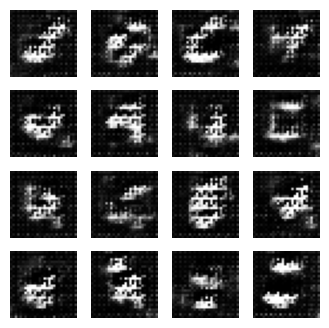

In [ ]:
n_rows = 4
fig,axs = plt.subplots(n_rows,n_rows,figsize=(4,4),sharex=True,sharey=True)
z = np.random.normal(0,1,(n_rows**2,z_dim))
#z = z/2 + 0.5
gen_imgs = generator.predict(z)
gen_imgs = gen_imgs/2 + 0.5
count = 0
for i in range(n_rows):
  for j in range(n_rows):
    axs[i,j].imshow(gen_imgs[count,:,:,0],cmap='gray')
    count = count + 1
    axs[i,j].axis('off')


In [ ]:
mnist_classifier = build_discriminator_supervised(
                         build_discriminator(img_shape))     

mnist_classifier.compile(loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [ ]:
x_train,y_train =dataset.batch_labeled(100)
mnist_classifier.fit(x=x_train,y=y_train,epochs=100)

Epoch 1/100
4/4 [==============================] - 6s 64ms/step - loss: 2.4328 - accuracy: 0.2200
Epoch 2/100
4/4 [==============================] - 0s 47ms/step - loss: 0.8255 - accuracy: 0.7500
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.4753 - accuracy: 0.8700
Epoch 4/100
4/4 [==============================] - 0s 51ms/step - loss: 0.2746 - accuracy: 0.9300
Epoch 5/100
4/4 [==============================] - 0s 46ms/step - loss: 0.1943 - accuracy: 0.9600
Epoch 6/100
4/4 [==============================] - 0s 50ms/step - loss: 0.1597 - accuracy: 0.9700
Epoch 7/100
4/4 [==============================] - 0s 53ms/step - loss: 0.1232 - accuracy: 0.9700
Epoch 8/100
4/4 [==============================] - 0s 53ms/step - loss: 0.1058 - accuracy: 0.9700
Epoch 9/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0832 - accuracy: 0.9900
Epoch 10/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0357 - accuracy: 1.0000
Epoch 11/100
4/4 [=

In [ ]:
x,y = dataset.testing_set()
_,accuracy = mnist_classifier.evaluate(x,y)
print("Test Accuracy for fully supervised classifier:",accuracy*100)

313/313 [==============================] - 6s 17ms/step - loss: 1.0258 - accuracy: 0.6800
Test Accuracy for fully supervised classifier: 68.00000071525574


### Another way
#### https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation
from matplotlib import pyplot
from tensorflow.keras import backend
 
# custom activation function
def custom_activation(output):
 logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
 result = logexpsum / (logexpsum + 1.0)
 return result
 
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
 # image input
 in_image = Input(shape=in_shape)
 # downsample
 fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
 fe = LeakyReLU(alpha=0.2)(fe)
 # downsample
 fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 # downsample
 fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 # flatten feature maps
 fe = Flatten()(fe)
 # dropout
 fe = Dropout(0.4)(fe)
 # output layer nodes
 fe = Dense(n_classes)(fe)
 # supervised output
 c_out_layer = Activation('softmax')(fe)
 # define and compile supervised discriminator model
 c_model = Model(in_image, c_out_layer)
 c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
 # unsupervised output
 d_out_layer = Lambda(custom_activation)(fe)
 # define and compile unsupervised discriminator model
 d_model = Model(in_image, d_out_layer)
 d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
 return d_model, c_model
 
# define the standalone generator model
def define_generator(latent_dim):
 # image generator input
 in_lat = Input(shape=(latent_dim,))
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 gen = Dense(n_nodes)(in_lat)
 gen = LeakyReLU(alpha=0.2)(gen)
 gen = Reshape((7, 7, 128))(gen)
 # upsample to 14x14
 gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
 gen = LeakyReLU(alpha=0.2)(gen)
 # upsample to 28x28
 gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
 gen = LeakyReLU(alpha=0.2)(gen)
 # output
 out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
 # define model
 model = Model(in_lat, out_layer)
 return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect image output from generator as input to discriminator
 gan_output = d_model(g_model.output)
 # define gan model as taking noise and outputting a classification
 model = Model(g_model.input, gan_output)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model
 
# load the images
def load_real_samples():
 # load dataset
 (trainX, trainy), (_, _) = load_data()
 # expand to 3d, e.g. add channels
 X = expand_dims(trainX, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 print(X.shape, trainy.shape)
 return [X, trainy]
 
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
 X, y = dataset
 X_list, y_list = list(), list()
 n_per_class = int(n_samples / n_classes)
 for i in range(n_classes):
     # get all images for this class
     X_with_class = X[y == i]
     # choose random instances
     ix = randint(0, len(X_with_class), n_per_class)
     # add to list
     [X_list.append(X_with_class[j]) for j in ix]
     [y_list.append(i) for j in ix]
 return asarray(X_list), asarray(y_list)
 
# select real samples
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = ones((n_samples, 1))
 return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 z_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = z_input.reshape(n_samples, latent_dim)
 return z_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 z_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict(z_input)
 # create class labels
 y = zeros((n_samples, 1))
 return images, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
 # prepare fake examples
 X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
 # scale from [-1,1] to [0,1]
 X = (X + 1) / 2.0
 # plot images
 for i in range(100):
     # define subplot
     pyplot.subplot(10, 10, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
 # save plot to file
 filename1 = 'generated_plot_%04d.png' % (step+1)
 pyplot.savefig(filename1)
 pyplot.close()
 # evaluate the classifier model
 X, y = dataset
 _, acc = c_model.evaluate(X, y, verbose=0)
 print('Classifier Accuracy: %.3f%%' % (acc * 100))
 # save the generator model
 filename2 = 'g_model_%04d.h5' % (step+1)
 g_model.save(filename2)
 # save the classifier model
 filename3 = 'c_model_%04d.h5' % (step+1)
 c_model.save(filename3)
 print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))
 
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
 # select supervised dataset
 X_sup, y_sup = select_supervised_samples(dataset)
 print(X_sup.shape, y_sup.shape)
 # calculate the number of batches per training epoch
 bat_per_epo = int(dataset[0].shape[0] / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 # calculate the size of half a batch of samples
 half_batch = int(n_batch / 2)
 print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
 # manually enumerate epochs
 for i in range(n_steps):
     # update supervised discriminator (c)
     [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
     c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
     # update unsupervised discriminator (d)
     [X_real, _], y_real = generate_real_samples(dataset, half_batch)
     d_loss1 = d_model.train_on_batch(X_real, y_real)
     X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
     d_loss2 = d_model.train_on_batch(X_fake, y_fake)
     # update generator (g)
     X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
     g_loss = gan_model.train_on_batch(X_gan, y_gan)
     # summarize loss on this batch
     print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
     # evaluate the model performance every so often
     if (i+1) % (bat_per_epo * 1) == 0:
         summarize_performance(i, g_model, c_model, latent_dim, dataset)
 
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
(100, 28, 28, 1) (100,)
n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000
2/2 [==============================] - 1s 255ms/step
>1, c[2.324,6], d[0.098,2.404], g[0.095]
2/2 [==============================] - 1s 322ms/step
>2, c[2.282,4], d[0.075,2.434], g[0.095]
2/2 [==============================] - 1s 219ms/step
>3, c[2.206,14], d[0.064,2.464], g[0.098]
2/2 [==============================] - 1s 247ms/step
>4, c[2.183,10], d[0.073,2.356], g[0.109]
2/2 [==============================] - 1s 197ms/step
>5, c[2.078,34], d[0.075,2.359], g[0.104]
2/2 [==============================] - 1s 195ms/step
>6, c[1.900,34], d[0.054,2.395], g[0.102]
2/2 [==============================] - 1s 232ms/step
>7, c[1.753,48], d[0.026,2.314], g[0.129]
2/2 [==============================] - 1s 213ms/step
>8, c[1.593,52], d[0.015,2.154], g[0.180]
2/2 [==============================] - 1s 230ms/step
>9, c[1.465,60], d[0.009,2.278], g[0.305]
2/2 [==============================] - 1

KeyboardInterrupt: 